In [67]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community
from matplotlib import cm
from funciones import *
import scipy.misc 
from scipy.sparse import csr_matrix
import scipy.sparse.csgraph as sc
import copy
import itertools

In [68]:
#------------------------------------------------------------------------------------------------------
#                                 Trabajo Computacional 3
#------------------------------------------------------------------------------------------------------

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml('dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv('dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)

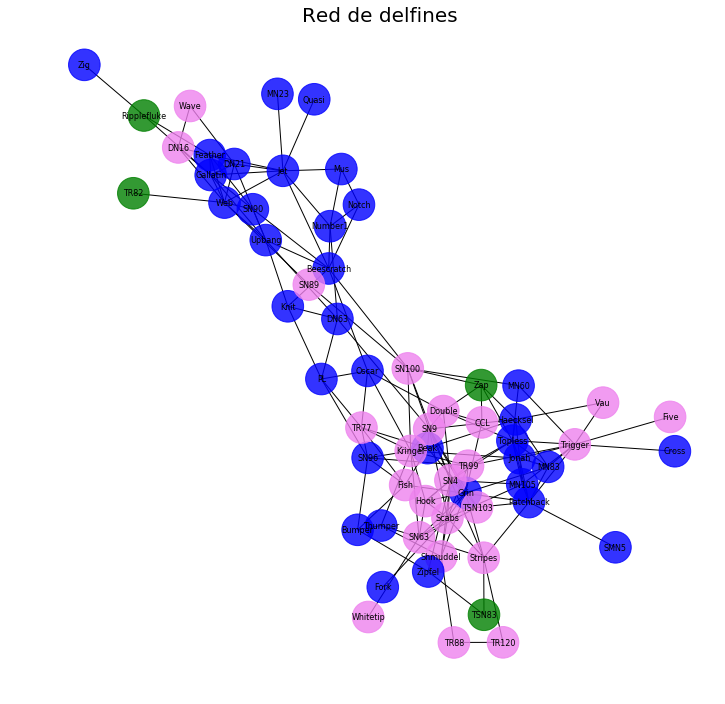

In [20]:
#------------------------------------------------------------------------------------------------------
#Grafico Original
#------------------------------------------------------------------------------------------------------
width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')
pos = nx.spring_layout(mydolphins)

#Nodos
nx.draw_networkx_nodes(mydolphins,
                       pos,
                       nodelist=mydolphins.nodes(),
                       node_color=["blue" if g=="m" else "violet" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()],
                       with_labels=True,node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [21]:
#------------------------------------------------------------------------------------------------------
#Metodo: Louvain
#------------------------------------------------------------------------------------------------------
G=mydolphins.copy()
part = community.best_partition(G) # diccionario con nodo - comunidad (nro)

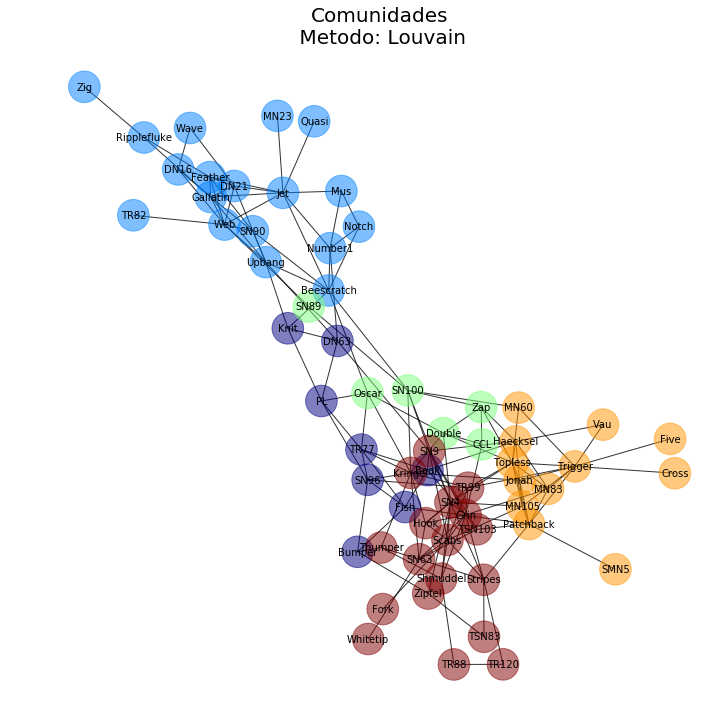

In [22]:
#------------------------------------------------------------------------------------------------------
#Visualizo comunidades
#------------------------------------------------------------------------------------------------------
comunidades=list(part.values())#lista de comunidades desordenada y repetidas
L=len(comunidades)#cantidad de nodos
a=np.unique(comunidades)
l=len(a) #cantidad de comunidades
delfines = G.nodes()

colores_com = np.linspace(0,1,l) # quiero n colores
colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera

width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

nx.draw_networkx_nodes(G,pos,
                       node_color = [colores[g] for g in part.values()],
                       node_size=1000,
                       alpha=0.5)

nx.draw_networkx_edges(G,pos,width=1.0,
                       alpha=0.8)
#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=10)
plt.title('Comunidades\n Metodo: Louvain',fontsize=20)
plt.axis('off')

plt.show()

In [23]:
#------------------------------------------------------------------------------------------------------
#Caracterización de Modularidad y Silhouette
#------------------------------------------------------------------------------------------------------
#Modularidad Total:
#-------------------------------------------------------------
#Matriz de Adyacencias Aij:
A = np.array(nx.to_numpy_matrix(G,nodelist=delfines))
N=G.number_of_nodes()
m=G.number_of_edges()
grado = dict(G.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for i,com_i in enumerate(comunidades):
    for j,com_j in enumerate(comunidades):
        if (com_i==com_j):
            C[i,j]=1
            
#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)
#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0
for ni, delfin_i in enumerate(delfines):
    for nj, delfin_j in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]
S2=S2/(2*m)
mod_tot=(S1-S2)/(2*m)

print('Modularidad Total = {0:.3f}'.format(mod_tot))

#------------------------------------------------------------------------------------------------------
#Modularidad de cada Partición:
#-------------------------------------------------------------

#Calculando la modularidad de cada comunidad:
modularidades=[]

for com in a:
    S1=0
    S2=0
    for ni, delfin_i in enumerate(delfines):
        for nj, delfin_j in enumerate(delfines):
            if com == list(part.values())[ni]:
                S1=S1+A[ni,nj]*C[ni,nj]
                S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]

    S2=S2/(2*m)
    mod=(S1-S2)/(2*m)
    modularidades.append(float(mod))
    

ls= [round(x, 3) for x in modularidades]

print('Modularidades por comunidad = ')
print(ls)

#Checkeo 
#print('Modularidad = {0:.3f}'.format(np.sum(modularidades)))

Modularidad Total = 0.519
Modularidades por comunidad = 
[0.065, 0.171, 0.03, 0.11, 0.142]


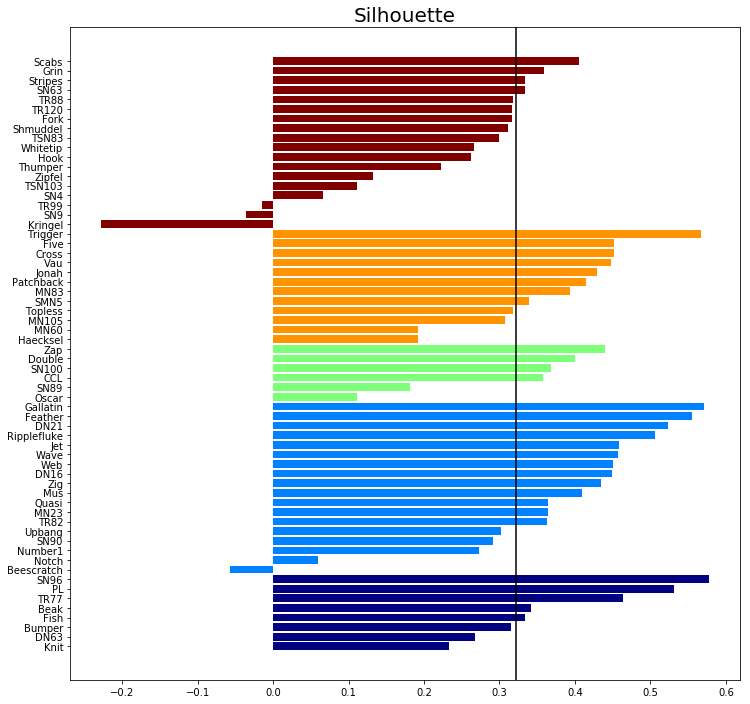

Valor promedio de Silhouette 0.32216956587829915


In [24]:
#------------------------------------------------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#Nota importante: list(part.keys())[i] representa el delfin en el lugar i-ésimo y comunidades es la lista de las comunidades de cada delfin
#Y que list(part.values())[i] representa la comunidad a la q pertenece

#Calculo a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for i,delfin_i in enumerate(delfines):
    distancias=[]
    for j, delfin_j in enumerate(delfines):
        if list(part.values())[i]==list(part.values())[j]:
               distancias.append(len(nx.shortest_path(G,delfin_i,delfin_j))-1)         
    promedio=np.mean(distancias)
    a.append(promedio)


#Calculo b[i]
b=[] #contendria para cada delfin la distancia promedio a nodos de otras comunidades, devuelvo el promedio minimo
ls=np.unique(comunidades)
for i,delfin_i in enumerate(delfines):
    distancias_prom=[] #es la lista q tiene mis distancias minimas 
    for c in ls: #recorro las comunidades
        distancias=[] #armo una lista que me indique las distancias por comunidad
        for j, delfin_j in enumerate(delfines): #recorro nuevamente para comparar
            if (list(part.values())[i]!=list(part.values())[j] and list(part.values())[j]==c): #Busco de forma ordenada los delfines
                #distancias.append((c, com_i, com_j,len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1)) #esto es para ver si funcionaba bien
                distancias.append(len(nx.shortest_path(G,delfin_i,delfin_j))-1)
        if len(distancias)!=0: #hay algunos c para los cuales la lista queda vacia
            distancias_prom.append(np.mean(distancias))
        
    b.append(min(distancias_prom))

#Calculo Silhouette    
S=[]
for i,com_i in enumerate(comunidades):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)
    #guardo la propiedad silhouette en el grafo:
    G.node[list(part.keys())[i]]['silhouette']=s

#-------------------------------------------------------------
#Grafico Silhouette:
outfolder ='C:/Users/lucio/Desktop/Facultad/Trabajos_Redes/datos/datosTP3'
width=12
height=12
plt.figure(figsize=(width, height))
delfines=np.sort(delfines)
y = []
yTicks = []
contador=-1
dtype = [('name', 'S21'),('silhouette', float)]
a=np.unique(comunidades)
for c in a:
    delf_S=[] #lista con pares de [delfin,silouette]
    for i,com_i in enumerate(comunidades): 
        if com_i==c:
            delf_S.append((str(list(part.keys())[i]),G.nodes[list(part.keys())[i]]['silhouette']))        
    delf_S=np.array(delf_S,dtype=dtype)
    delf_S=np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S=list(delf_S)
    
    for j,d in enumerate(delf_S):
        contador=contador+1
        delfin=str(delf_S[j][0],'utf-8')
        silhouette_value=delf_S[j][1]
        plt.barh(contador,silhouette_value,color = colores[c])#grafico una barra
        y.append(contador)
        yTicks.append(delfin)
plt.yticks(y, yTicks)
plt.yticks(range(len(delfines)),yTicks)
plt.axvline(np.mean(S), c="black",label='Red real')
plt.title('Silhouette',fontsize=20)
plt.savefig(outfolder+'silhouette.png')
plt.show()


print('Valor promedio de Silhouette',np.mean(S))

C:\Users\Lucio\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


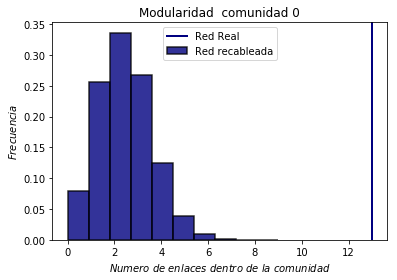

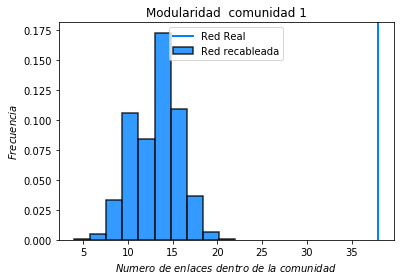

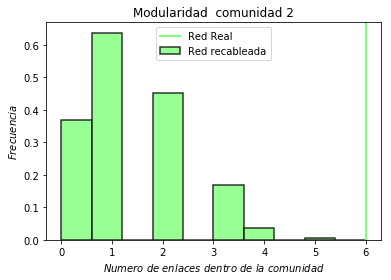

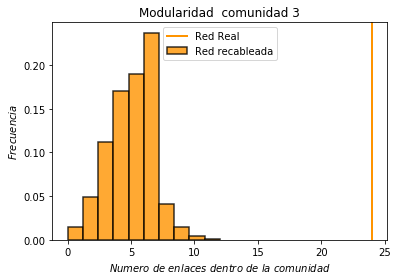

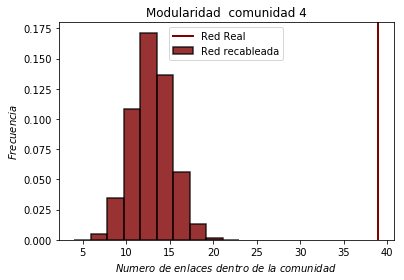

In [26]:
#------------------------------------------------------------------------------
#Rewiring:
#------------------------------------------------------------------------------
#EL PROGRAMA TARDA PARA 20000 ITERACIONES APROXIMADAMENTE 25 MIN, O SEA: 0.075 seg POR ITERACION

#Se podria tomar la red original recablear, y luego para las comunidades encontradas
#en la red original contar los enlaces que se hayan entre esos nodos.
#O sea estariamos calculando de forma simulada el valor kikj/2L.
#Haremos un histograma del numero de enlaces en esa comunidad.

G=mydolphins.copy()
Recableados={} #es un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','lc_real','lc_random'].
               #lc_random es una lista de tamano 'iteraciones' y que contiene el numero de enlaces dentro de esa comunidadn uno de esos recableados

a=np.unique(comunidades) #a es un vector que tiene las comunidades [0,1,2,3,4]
lc_random=[]
for c in a:
    lc_random.append([])

#Recableamos y contamos enlaces en cada comunidad

#iteraciones=20000 #descomentar para que corra
for it in range(0,iteraciones):
    D=rewiring(G) #creamos un nuevo grafo recableado:
    D_ady = np.array(nx.to_numpy_matrix(D,nodelist=delfines))
    for c in a:
        enlaces=0
        for ni, delfin_i in enumerate(delfines):
            for nj, delfin_j in enumerate(delfines):
                if c==list(part.values())[ni] == list(part.values())[nj]:
                    enlaces=enlaces+D_ady[ni,nj]
        lc_random[c].append(int(enlaces)/2)
        Recableados['comunidad'+str(c)]={'color':colores[c],'lc_real':0,'lc_random':list(lc_random[c])}

#Contamos enlaces en cada comunidad de la red original:
for c in a:
    enlaces=0
    for ni, delfin_i in enumerate(delfines):
        for nj, delfin_j in enumerate(delfines):
            if c==list(part.values())[nj] == list(part.values())[ni]:
                enlaces=enlaces+A[ni,nj]
    enlaces=int(enlaces)/2
    Recableados['comunidad'+str(c)]['lc_real']=enlaces


#Graficamos:

'''
outfolder ='C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/'
for c in a:
    plt.figure(c)
    plt.hist(Recableados['comunidad'+str(c)]['lc_random'],color=colores[c],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1)
    plt.axvline(x=Recableados['comunidad'+str(c)]['lc_real'],color=colores[c],linewidth=2,label='Red Real')
    plt.xlabel('$Numero$ $de$ $enlaces$ $dentro$ $de$ $la$ $comunidad$')
    plt.ylabel('$Frecuencia$')
    plt.legend(loc='upper center')
    plt.title('Modularidad '+' comunidad '+str(c))
    plt.savefig(outfolder+'comunidad_'+str(c)+'_hist.png')


#Output
for c in a:
    lc_real=Recableados['comunidad'+str(c)]['lc_real'] #numero de enlaces dentro de la comunidad en la red real
    lc_rewiring=np.mean(Recableados['comunidad'+str(c)]['lc_random'])#numero de enlaces promedio dentro de la comunidad para un cierto numero de redes recableadas.
    modularidad_por_rewiring=(lc_real-lc_rewiring)/m #dividimos por el numero de enlaces totales.
    
    output={}
    output['comunidad']=Recableados['comunidad'+str(c)]['color']
    output['enlaces_red_real']=lc_real
    output['enlaces_red_recabelada']=lc_rewiring
    output['modularidad por rewiring']=modularidad_por_rewiring
    output['modularidad por cuenta teorica']=modularidades[c]
    output['enlaces_red_random']=list(Recableados['comunidad'+str(c)]['lc_random'])
    df= pd.DataFrame()
    df['Date'] = output.keys()
    df['DateValue'] = output.values()
    df.to_csv(outfolder+'comunidad_'+str(c)+'_data.txt',sep='\t')
'''


 

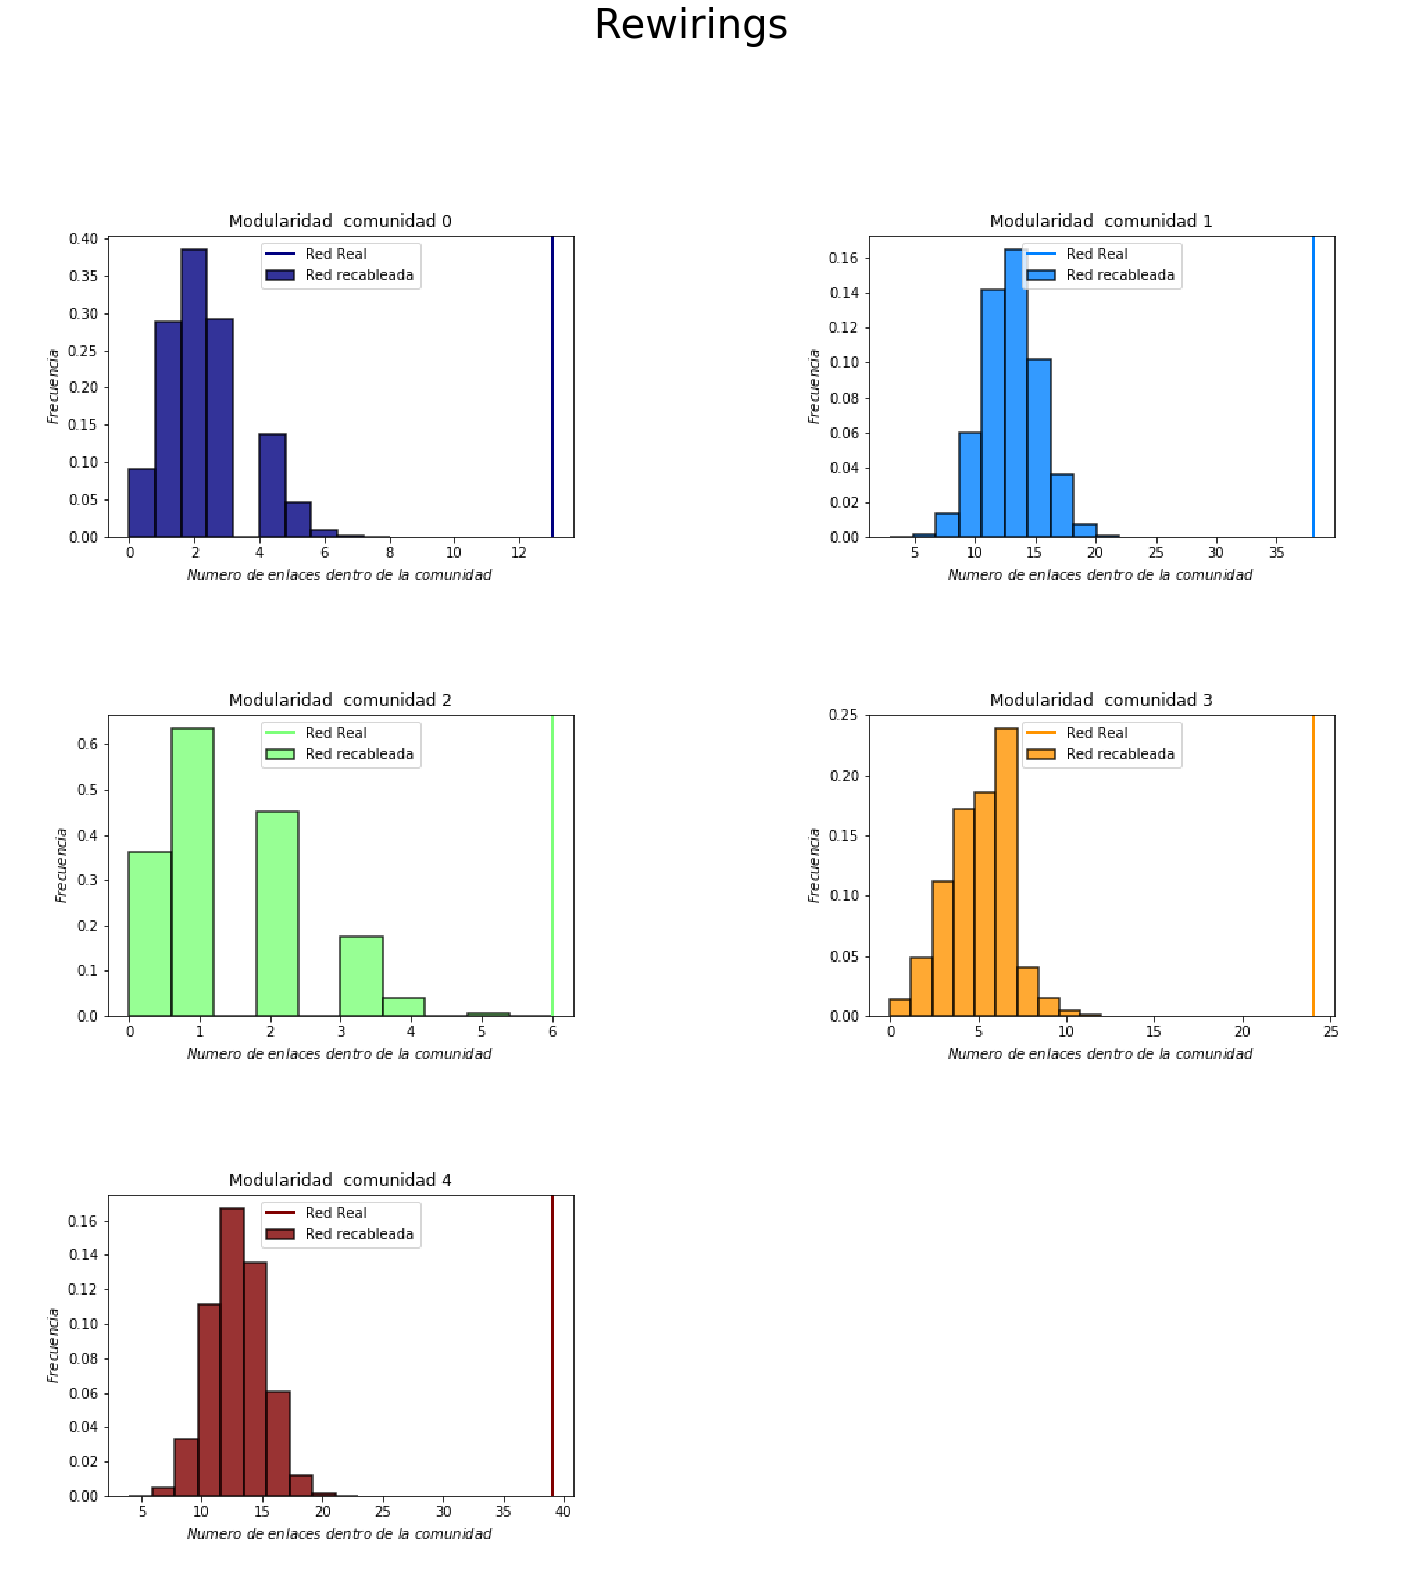

In [9]:
plt.figure(figsize=(25,25))
plt.suptitle('Rewirings',fontsize=40)

plt.subplot(3,2,1)
#fig0=plt.figure(figsize=(8,8))
comunidad_0=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_0_hist.png')
plt.imshow(comunidad_0)
plt.axis('off')

plt.subplot(3,2,2)
comunidad_1=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_1_hist.png')
plt.imshow(comunidad_1)
plt.axis('off')

plt.subplot(3,2,3)
comunidad_2=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_2_hist.png')
plt.imshow(comunidad_2)
plt.axis('off')

plt.subplot(3,2,4)
comunidad_3=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_3_hist.png')
plt.imshow(comunidad_3)
plt.axis('off')

plt.subplot(3,2,5)
comunidad_4=plt.imread('C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/comunidad_4_hist.png')
plt.imshow(comunidad_4)
plt.axis('off')

plt.show()



In [ ]:
#------------------------------------------------------------------------------
#Comparación:
#------------------------------------------------------------------------------

In [20]:
#------------------------------------------------------------------------------
#Relación de género:
#------------------------------------------------------------------------------
Generos={} #Es  un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','dc','fc','mc','pFish','pvalor'].
           #dc: numero de delfines en la comunidad. 
           #fc: numero de hembras en la comunidad.
           #mc: numero de machos en la comunidad.
           #pFish: probabilidad de que hayan hc hembras en la comunidad por azar. pFish=(F fc)(N-F dc-fc)/(N dc)  donde (A a)=A!/a!(A-a)!
           #D: numero total de delfines
           #F: numero total de hembras
           #M: numero total de machos

G=mydolphins.copy()
delfinesF=[delfines[i] for i,idelfin in enumerate(delfines) if G.node[idelfin]['gender']=='f']
delfinesM=[delfines[i] for i,idelfin in enumerate(delfines) if G.node[idelfin]['gender']=='m']
F=len(delfinesF)
M=len(delfinesM)
D=M+F
a=np.unique(comunidades)
#Voy a almacenar los datos
Ndel=[]
Nhem=[]
Nmac=[]
pFisher=[]
pValor=[]

for c in a:
    dc=0
    fc=0
    mc=0
    for ni, delfin_i in enumerate(delfines):
        if c==list(part.values())[ni] and G.node[delfin_i]['gender']=='f':
            dc=dc+1
            fc=fc+1
        elif c==list(part.values())[ni] and G.node[delfin_i]['gender']=='m':
            dc=dc+1
            mc=mc+1
        else:
            mc=mc
            fc=fc
    Ndel.append(dc)
    Nhem.append(fc)
    Nmac.append(mc)
    #Calculo el Fisher
    pFish=scipy.misc.comb(F,fc)*scipy.misc.comb(D-F,dc-fc)/scipy.misc.comb(D,dc)
    pFisher.append(pFish)
    #Calculo del pvalor:
    pvalor=0
    for f in range(fc,F+1):
        pvalor=pvalor+(scipy.misc.comb(F,f)*scipy.misc.comb(N-F,dc-f)/scipy.misc.comb(N,dc))
    pValor.append(pvalor)
    
    Generos['comunidad'+str(c)]={'dc':dc,'fc':fc,'mc':mc,'pFish':round(pFish,4),'pvalor':round(pvalor,4)}


#levanto la data del rewiring
outfolder ='C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/'
enlaces_red_real=[]
enlaces_red_rewiring=[]#valor medio del histograma
modularidad_rewiring=[]
modularidades_teo=[]
for c in a:
    data = pd.read_csv(outfolder+'/iter=30k/'+'comunidad_'+str(c)+'_data.txt',sep='\t') 
    
    enlaces_red_real.append(round(float(data.loc[1,"DateValue"]),4))
    enlaces_red_rewiring.append(round(float(data.loc[2,"DateValue"]),4))
    modularidad_rewiring.append(round(float(data.loc[3,"DateValue"]),4))
    modularidades_teo.append(round(float(data.loc[4,"DateValue"]),4))


tabla_resumen = pd.DataFrame({"Comunidades":["Comunidad0","Comunidad1","Comunidad2","Comunidad3","Comunidad4"],
                    "Modularidad (teórica)":modularidades_teo, #es = que modularidades
                    "Modularidad (rewiring)":modularidad_rewiring,
                    "Enlaces (red real)":enlaces_red_real,
                    "Enlaces (red rewiring)":enlaces_red_rewiring,
                    "Ndelfines":Ndel,
                    "Nhembras":Nhem,
                    "Nmachos":Nmac,
                    "pFischer":pFisher,
                    "pValor":pValor,
                   })
tabla_resumen

C:\Users\Lucio\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
C:\Users\Lucio\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


,Comunidades,Modularidad (teórica),Modularidad (rewiring),Enlaces (red real),Enlaces (red rewiring),Ndelfines,Nhembras,Nmachos,pFischer,pValor
0,Comunidad0,0.0651,0.0677,13.0,2.2379,8,3,5,0.293818,0.670599
1,Comunidad1,0.1709,0.1568,38.0,13.0730,17,4,13,0.049916,0.967006
2,Comunidad2,0.0300,0.0294,6.0,1.3301,5,3,2,0.247803,0.288852
3,Comunidad3,0.1104,0.1200,24.0,4.9136,12,4,8,0.216337,0.772240
4,Comunidad4,0.1424,0.1643,39.0,12.8842,16,10,6,0.032988,0.025204


3
Numero de comunidades encontradas: 4
Comunidad 0: numerodecliques: 4 numerodedelfines: 5
Comunidad 1: numerodecliques: 26 numerodedelfines: 13
Comunidad 2: numerodecliques: 9 numerodedelfines: 9
Comunidad 3: numerodecliques: 56 numerodedelfines: 25


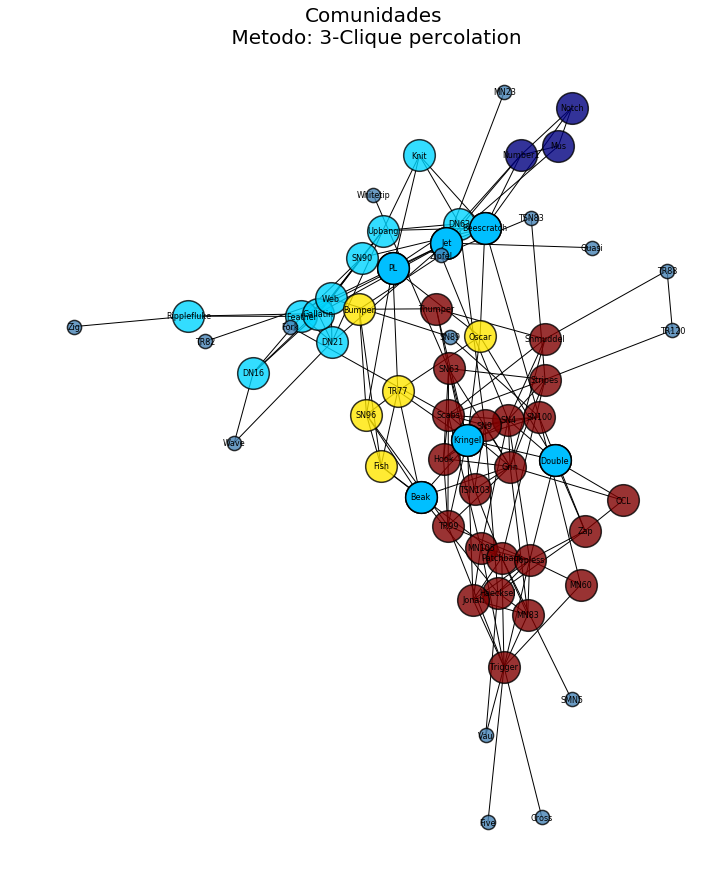

4
Numero de comunidades encontradas: 3
Comunidad 0: numerodecliques: 9 numerodedelfines: 8
Comunidad 1: numerodecliques: 7 numerodedelfines: 9
Comunidad 2: numerodecliques: 10 numerodedelfines: 7


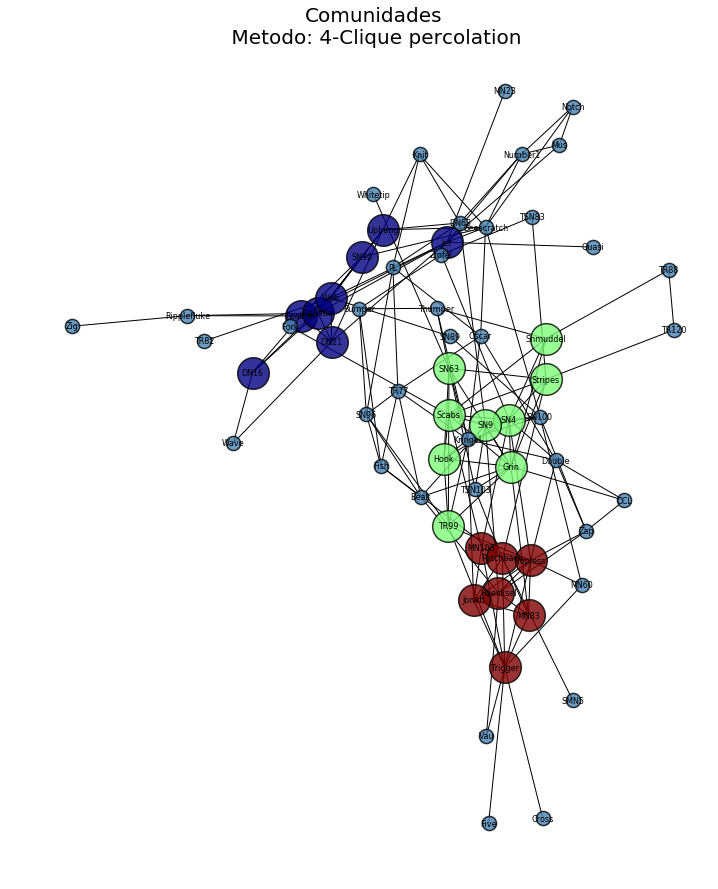

5
Numero de comunidades encontradas: 1
Comunidad 0: numerodecliques: 2 numerodedelfines: 6


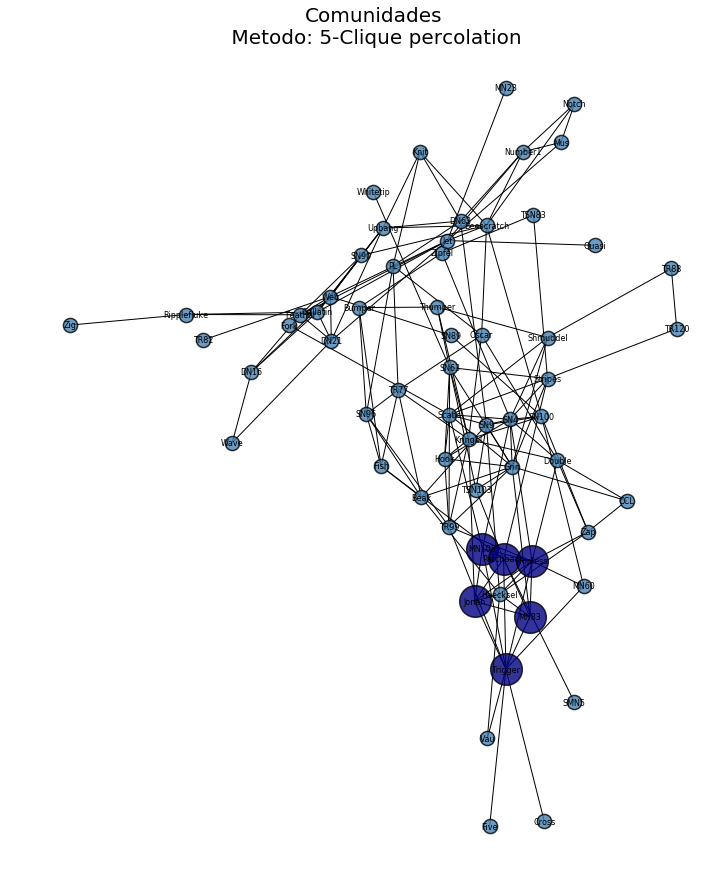

In [59]:
#-----------------------------------------------------------------------------------------------------------------------------
#2)Percolación de k-Cliques:
#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
#Parte A) Calculos previos:
#-----------------------------------------------------------------------------------------------------------------------------
#print('Clique Percolation...')

for k in range(3,6):
    print(k)
    cliques=list(nx.enumerate_all_cliques(mydolphins))
    #k=3 #Tipo de k-cliques que queremos percolar.
    cliques_k=[] #nos quedamos con los k_cliques.
    for c,clique in enumerate(cliques):
        if len(clique)==k:
            cliques_k.append(clique)

    #CLiques_k es la matriz de Overlap de k-cliques:
    Cliques_k=np.zeros((len(cliques_k),len(cliques_k)))

    for i,iclique in enumerate(cliques_k):
        for j,jclique in enumerate(cliques_k):
            if len(set(iclique).intersection(set(jclique)))==k-1:#dos 3-cliques se overlapean si son adyacentes o sea si comparten un link.
                Cliques_k[i][j]=1
                Cliques_k[j][i]=1

    #Usamos el algoritmo de reverse_cuthill_mckee para generar una matriz de bloques:(creo que debe ser similar a hacer formad de Jordan este algoritmo)
    #(No creo que sea del todo necesario pero creo que reduce el tiempo de computo para lo que viene despues)

    A=Cliques_k

    A=np.array(A)
    B=csr_matrix(A) #Cliques_tres en forma sparse para poder pasarselo al metodo se necesita la matriz en esta forma
    C=np.zeros((np.shape(A)[0],np.shape(A)[0]))
    orden=sc.reverse_cuthill_mckee(B,symmetric_mode=True) #ordena los vectores columna en la matriz A de forma de obtener una matriz C de bloques.
    orden=list(orden)
    for i,o in enumerate(orden):
        for j,p in enumerate(orden):
            C[i,j]=A[o][p]

    #cliques hay que ordenarlo segun el vector orden.
    cliques_k_ordenados=[]
    for c,clique in enumerate(cliques_k):
        nuevo=copy.deepcopy(cliques_k[orden[c]])
        cliques_k_ordenados.append(nuevo)

#-----------------------------------------------------------------------------------------------------------------------------
#Parte B) Percolacion de cliques:
#-----------------------------------------------------------------------------------------------------------------------------
#Hasta aca tenemos cliques_tres_ordenados.
#Ahora tenemos que encontrar las comunidades:
#Hago una copia de cliques que tengo:

    cliques=copy.deepcopy(cliques_k_ordenados) #lo copiamos ya que vamos a ir eliminando cliques de la lista cliques pero cliques_tres_ordenados la conservamos intacta

    #Estrategia: vamos buscando cliques en la lista cliques y cuando son adyaentes los agarro y los agrego a la lista comunidad_cliques
    Comunidades=[]
    comunidad_cliques=[copy.deepcopy(cliques[0])] #acá es donde vamos a ir poniendo los cliques que vamos encontrando que son adyacentes
                                                  #el valor inicial de la comunidad_cliques son los delfines del primer clique de la lista cliques

    while len(cliques)>1: #terminamos cuando se me acabaron los cliques en a lista cliques
        cliques_to_remove=[] #cuando encuentro que hay una interseccion entre el jclique con algno de la comunidad lo tengo que eliminar de la lista cliques
        cliques_to_remove.append(0)#asi elimino tambien el primer elemento
        #print('cliques actualizados:')
        #print(cliques)

        tamanocliquesold=len(cliques) 
        tamanocliquesnew=len(cliques)+1

        #Lo siguiente es MUCHO MUY IMPORTANTE!:
        #una vez que termino te recorrer cliques y agregarlos a comunidad_cliques hay que aseguarse que no queden cliques en la lista clique que puedan corresponder
        #a la comunidad que estoy armando en comunidad_cliques.
        #esto puede pasar porque el link compartido se pudo formar despues y nunca lo vi,mos entonces...hay que iterar hasta que el largo del vector comunidad_cliques ya no cambie.

        while tamanocliquesnew-tamanocliquesold > 0: #Hay que iterar hasta que este vector ya no cambie mas su largo!!: 
            tamanocliquesold=len(comunidad_cliques)  
            for j in range(0,len(cliques)):
                for cc, cclique in enumerate(comunidad_cliques):
                    if len(set(cliques[j]).intersection(set(cclique)))==k-1:
                        comunidad_cliques.append(cliques[j])#guardo el clique en vez de los nodos y siempre comparo con cliques NO con nodos
                        cliques_to_remove.append(j)
                        #eliminamos elementos repetidos tanto de remove como de comunidad_cliques
                        comunidad_cliques.sort()
                        comunidad_cliques=list(comunidad_cliques for comunidad_cliques,_ in itertools.groupby(comunidad_cliques))#elimino elementos repetidos
                        #print('comunidad')
                        #print(comunidad_cliques)
                        cliques_to_remove=list(np.unique(cliques_to_remove))
                        #print(cliques_to_remove)
            tamanocliquesnew=len(comunidad_cliques)

        newcliques= [z for i, z in enumerate(cliques) if i not in cliques_to_remove] #actualizamos cliques borrando los que ya encontramos que hubo interseccion
        cliques=copy.deepcopy(newcliques)

    #    print('comunidad final')
    #    print(comunidad_cliques) 

        Comunidades.append(comunidad_cliques)
        if len(cliques)>0:
            comunidad_cliques=[copy.deepcopy(cliques[0])]

    #print('Listo Clique Percolation')
    
#-----------------------------------------------------------------------------------------------------------------------------
#Parte C) post-Calculos :
#-----------------------------------------------------------------------------------------------------------------------------

    numero_comunidades=len(Comunidades)
    print('Numero de comunidades encontradas: {}'.format(numero_comunidades))

    #Teminamos de armar las comunidades a partir de los cliques que estan en cada component de Comunidades[i]:
    comunidades_perc=[] #lista que contiene en cada posicion una comunidad que es la lista de delfines que pertenecen a la misma
    delfines_alcanzados=[]

    for c,com in enumerate(Comunidades):
        delfines=[]
        for cl, clique in enumerate(com):
            for grado in range(0,k):
                delfines.append(clique[grado])
                delfines_alcanzados.append(clique[grado])
        comunidades_perc.append(list(np.unique(delfines)))

    delfines_alcanzados=list(np.unique(delfines_alcanzados))

    for c,com in enumerate(Comunidades):
        print('Comunidad {}: numerodecliques: {} numerodedelfines: {}'.format(c,len(com),len(comunidades_perc[c])))

    #Nodos overlapping:
    overlap_comunidades=[]
    for c,icom in enumerate(comunidades_perc):
        overlap_row=[]
        for d,jcom in enumerate(comunidades_perc):
            if c!=d:
                overlap_row.append(list(set(icom).intersection(set(jcom))))
            else:
                overlap_row.append([])
        overlap_comunidades.append(overlap_row)

    #Nodos faltantes: son nodos a los que el metodo no pudo llegar los vamos a graficar en tamaño mas chico:
    #comparamos con la lista de delfines_alcanzados con la lista de delfines
    delfines_originales=mydolphins.nodes()
    delfines_faltantes=set(delfines_originales).difference(set(delfines_alcanzados))

#----------------------------------------    
#Grafico:
#----------------------------------------

    #colores=['blue','red','orange','green']
    l=len(comunidades_perc)
    colores_com = np.linspace(0,1,l) # quiero n colores
    colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera


    fig = plt.figure(figsize=(12,15))
    fig.patch.set_facecolor('white')

    #Nodos alcanzados por clique percolation
    for c,comu in enumerate(comunidades_perc):
        nx.draw_networkx_nodes(mydolphins,pos,nodelist=comu,node_color=colores[c],node_size=1000,alpha=0.8,linewidths=1.5,edgecolors='black')

    #Nodos con overlapping entre comunidades:
    for i in range(0,len(overlap_comunidades)):
       for j in range(i,len(overlap_comunidades)): 
        nx.draw_networkx_nodes(mydolphins,pos,nodelist=overlap_comunidades[i][j],node_color='deepskyblue',node_shape='o',node_size=1000,alpha=1,linewidths=1.5,edgecolors='black')   

    #Nodos faltantes:
    nx.draw_networkx_nodes(mydolphins,pos,nodelist=delfines_faltantes,node_color='steelblue',node_size=200,alpha=0.8,linewidths=1.5,edgecolors='black')

    #Enlaces
    nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

    #Etiquetas
    nx.draw_networkx_labels(mydolphins,pos,font_size=8)
    plt.title('Comunidades\n Metodo: '+str(k)+'-Clique percolation',fontsize=20)
    plt.axis('off')
    plt.savefig(outfolder+'percolacion_'+str(k)+'_fig.png')
    plt.show()



p valor: 0.0019000000000000128


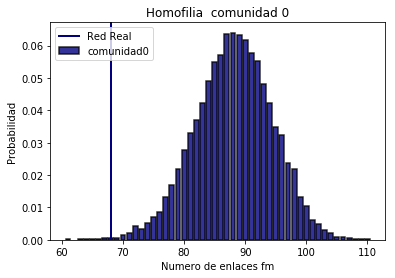

p valor: 0.6395


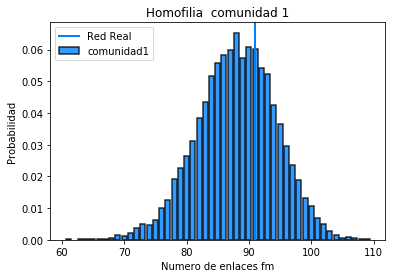

p valor: 0.08890000000000009


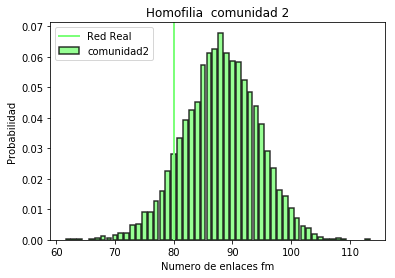

p valor: 0.5888


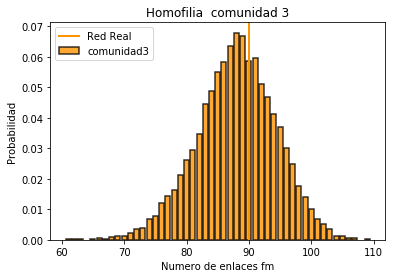

p valor: 0.4563999999999999


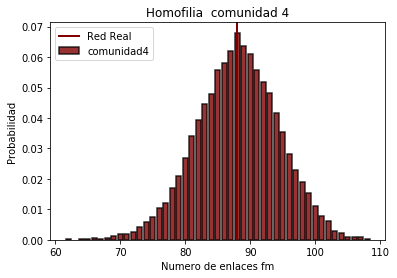

,Comunidades,Valor medio(H null),Desviacion Standar,Valor Red Real
0,Comunidad0,88.1136,6.3098,88
1,Comunidad1,88.0381,6.3106,88
2,Comunidad2,88.0176,6.3015,88
3,Comunidad3,88.0186,6.3455,88
4,Comunidad4,88.0452,6.3382,88


In [34]:
#------------------------------------------------------------------------------------------
#Homofilia
#------------------------------------------------------------------------------------------

G=mydolphins.copy()
a=np.unique(comunidades) #a es un vector que tiene las comunidades [0,1,2,3,4]
mean_enlacesfm = []
desv_enlacesfm = []

for c in a:

    Enlaces_fm = [] # Lista donde vamos a almacenar la cantidad de enlaces entre géneros distintos

    # Hacemos N asignaciones aleatorias de género:
    num_asignaciones = 10000

    for it in range(num_asignaciones):
        if it==0:
            genero_shuffle = genero # Conservamos la red real en la primera iteración
        else:
            genero_shuffle = genero
            np.random.shuffle(genero_shuffle) # Reordenamos aleat los generos para el resto de las iteraciones

        # Reasignamos a cada nodo un valor de genero del vector de genero_shuffle:
        for d,g in zip(delfines,genero_shuffle):
            G.add_node(d, gender=g)

        #Contamos la fraccion de enlaces que conecta nodos con diferente genero:
        enlaces = list(G.edges.data())
        enlaces_fm = 0 # Ponemos en cero el contador de enlaces cruzados
        # Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
        for i in range(0,len(enlaces)-1):
            genero1 = G.nodes[enlaces[i][0]]['gender']
            genero2 = G.nodes[enlaces[i][1]]['gender']
            if genero1 != genero2:   # Comparamos los generos e incrementamos el contador si los generos son diferentes
                enlaces_fm += 1 
        Enlaces_fm.append(enlaces_fm) # Guardamos la cantidad de enlaces f-m en cada iteración

    # Ahora tenemos una lista Enlaces_fm con la cantidad de enlaces cruzados para N iteraciones
    # Recordamos que la primera componente corresponde a la red real

    # Valor medio y desviacion standar
    mean_enlacesfm.append(round(np.mean(Enlaces_fm),4))
    desv_enlacesfm.append(round(np.std(Enlaces_fm),4))
    
#----------------------------------------------------  

    outfolder ='C:/Users/Lucio/Desktop/FACULTAD/Redes/datos/datosTP3/'
    colores_com = np.linspace(0,1,l) # quiero n colores
    colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera
   
    # Histograma y p-valor:
    histograma = np.unique(Enlaces_fm,return_counts=True)
    k_enlacesfm = histograma[0] # El vector cantidad de enlaces fm, ordenado
    probabilidad = histograma[1]/float(num_asignaciones) # Cantidad de veces que aparece cada valor de enlaces, normalizado

    # p-valor: la probabilidad que queda acumulada a la izq del numero de enlaces_fm de la red real
    # Buscamos el k_enlacesfm mas cercano al de la red real
    closestto = Enlaces_fm[0]
    theclosest = min(histograma[0], key=lambda x:abs(x-closestto)) # devuelve el k_enlacesfm más cercano al valor real
    theclosest_index = int(np.where(histograma[0] == theclosest)[0]) # devuelve el indice correspondiente al valor anterior

    # Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha
    pvalue=1-np.sum(probabilidad[theclosest_index :])
    print ('p valor: {}'.format(pvalue))


    plt.figure(c)
    plt.bar(k_enlacesfm,
             probabilidad,
             color=colores[c],
             linewidth=1.5,
             edgecolor='black',
             label='comunidad'+str(c),
             alpha=0.8,
             )
    plt.axvline(Enlaces_fm[0],
                color=colores[c],
                linewidth=2,
                label='Red Real')
    plt.xlabel('Numero de enlaces fm')
    plt.ylabel('Probabilidad')
    plt.legend(loc='upper left')
    plt.title('Homofilia '+' comunidad '+str(c))
    plt.savefig(outfolder+'Homofilia'+' comunidad '+str(c)+'.png')
    plt.show()

tabla_resumen = pd.DataFrame({"Comunidades":["Comunidad0","Comunidad1","Comunidad2","Comunidad3","Comunidad4"],
                    'Valor medio(H null)':mean_enlacesfm, 
                    'Desviacion Standar':desv_enlacesfm,
                    'Valor Red Real':Enlaces_fm[0]
                   })
tabla_resumen




Calculando Homofilia en comunidades
Comunidad:0
Distribucion de enlaces fm:
Valor medio(H null): 8.82
Desviacion Standar: 1.26
Valor Red Real: 9.00
p valor: 0.3416


C:\Users\lucio\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


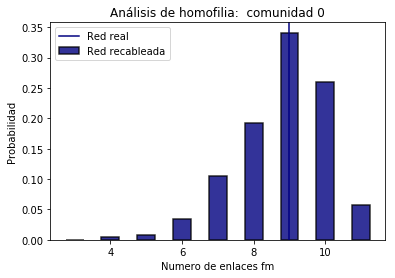

Comunidad:1
Distribucion de enlaces fm:
Valor medio(H null): 24.10
Desviacion Standar: 2.67
Valor Red Real: 20.00
p valor: 0.0445


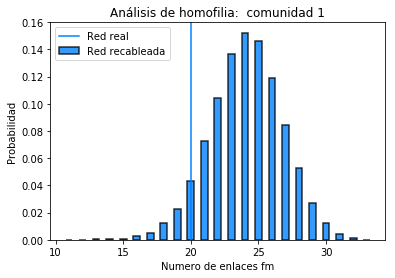

Comunidad:2
Distribucion de enlaces fm:
Valor medio(H null): 2.00
Desviacion Standar: 0.82
Valor Red Real: 3.00
p valor: 0.6627


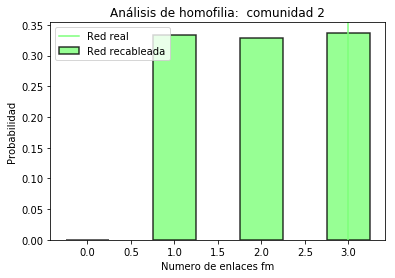

Comunidad:3
Distribucion de enlaces fm:
Valor medio(H null): 14.89
Desviacion Standar: 1.84
Valor Red Real: 15.00
p valor: 0.4181


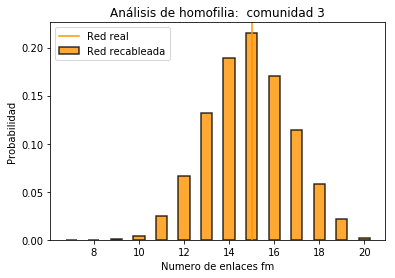

Comunidad:4
Distribucion de enlaces fm:
Valor medio(H null): 18.37
Desviacion Standar: 2.93
Valor Red Real: 19.00
p valor: 0.4945


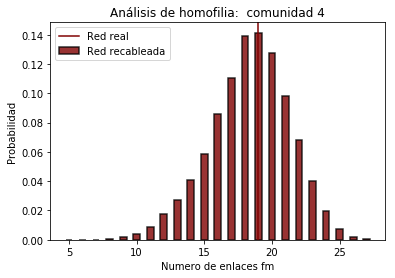

NameError: name 'Enlaces_fm' is not defined

In [69]:

#-----------------------------------------------------------------------------------------------------------------------------
#1d)Extras Analisis de homofilia:
#-----------------------------------------------------------------------------------------------------------------------------
#Vamos a hacerlo de dos maneras al igual que lo que hicimos en el tp1:
#a) Utilizando primero una reasignacion de los generos dentro de cada comunidad
#y comparando con la cantidad de enlaces entre distintos generos(numero de enlaces fm)
#de la red real.
print('Calculando Homofilia en comunidades')

outfolder ='C:/Users/Lucio/Desktop/Facultad/Trabajos_Redes/datos/datosTP3/'

Enlaces_fm_comunidades= [] # Lista donde vamos a almacenar la cantidad de enlaces entre géneros distintos
Enlaces_fm_comunidad=[]

Generos_comunidades=[]
Generos_comunidad=[]

mean_enlacesfm_comunidades=[]
desv_enlacesfm_comunidades=[]

histogramas_comunidades=[]
pvalue_comunidades=[]

a=np.unique(comunidades)

for c in a:
    Generos_comunidad=[]
    for d,delfin in enumerate(delfines):
            if c==list(part.values())[d]:
                Generos_comunidad.append(mydolphins.nodes[delfin]['gender'])
    Generos_comunidades.append(Generos_comunidad)

Comunity_graphs=[]


for i in a:
    Comunity_graph=copy.deepcopy(mydolphins)
    for j in a:
        if j!=i:
            ls = [n for n,v in part.items() if v == j]#lista con todos los nodos que pertenecen a la comunidad j
            Comunity_graph.remove_nodes_from(ls)
    Comunity_graphs.append(Comunity_graph)


# Hacemos N asignaciones aleatorias de género:
num_asignaciones = 20000

for cg, comgraph in enumerate(Comunity_graphs):
    delfines = [n for n,v in part.items() if v == cg]
    #delfines=comunidades[cg]
    Enlaces_fm_comunidad= []
    for it in range(0,num_asignaciones):
        if it==0:
            genero_shuffle = Generos_comunidades[cg] # Conservamos la red real en la primera iteración
        else:
            genero_shuffle = Generos_comunidades[cg] 
            np.random.shuffle(genero_shuffle) # Reordenamos aleat los generos para el resto de las iteraciones

        #Reasignamos a cada nodo un valor de genero del vector de genero_shuffle:
        for d,g in zip(delfines,genero_shuffle):
            Comunity_graphs[cg].add_node(d, gender=g)

        #Contamos la fraccion de enlaces que conecta nodos con diferente genero:
        enlaces = list(Comunity_graphs[cg].edges.data())
        enlaces_fm = 0 # Ponemos en cero el contador de enlaces cruzados
        # Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
        for i in range(0,len(enlaces)):
            genero1 = Comunity_graphs[cg].nodes[enlaces[i][0]]['gender']
            genero2 = Comunity_graphs[cg].nodes[enlaces[i][1]]['gender']
            if (genero1 != genero2) & (genero1 is not float) & (genero2 is not float): 
                enlaces_fm += 1 # Incrementamos el contador si los generos son diferentes
        Enlaces_fm_comunidad.append(enlaces_fm) # Guardamos la cantidad de enlaces f-m en cada iteración
    Enlaces_fm_comunidades.append(Enlaces_fm_comunidad)

    # Ahora tenemos una lista Enlaces_fm con la cantidad de enlaces cruzados para N iteraciones
    # Recordamos que la primera componente corresponde a la red real

    # Valor medio y desviacion standar
    mean_enlacesfm = np.mean(Enlaces_fm_comunidad)
    mean_enlacesfm_comunidades.append(mean_enlacesfm)
    desv_enlacesfm = np.std(Enlaces_fm_comunidad)
    desv_enlacesfm_comunidades.append(desv_enlacesfm)
    
    print('Comunidad:{}'.format(cg))
    print ('Distribucion de enlaces fm:')
    print ('Valor medio(H null): {0:.2f}'.format(mean_enlacesfm))
    print ('Desviacion Standar: {0:.2f}'.format(desv_enlacesfm))
    print ('Valor Red Real: {0:.2f}'.format(Enlaces_fm_comunidad[0]))


    # Histograma y p-valor:
    histograma = np.unique(Enlaces_fm_comunidad,return_counts=True)
    histogramas_comunidades.append(histograma)
    k_enlacesfm = histograma[0] # El vector cantidad de enlaces fm, ordenado
    probabilidad = histograma[1]/float(num_asignaciones) # Cantidad de veces que aparece cada valor de enlaces, normalizado

    # p-valor: la probabilidad que queda acumulada a la izq del numero de enlaces_fm de la red real
    # Buscamos el k_enlacesfm mas cercano al de la red real
    closestto = Enlaces_fm_comunidad[0]
    theclosest = min(histograma[0], key=lambda x:abs(x-closestto)) # devuelve el k_enlacesfm más cercano al valor real
    theclosest_index = int(np.where(histograma[0] == theclosest)[0]) # devuelve el indice correspondiente al valor anterior

    # Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha
    pvalue=1-np.sum(probabilidad[theclosest_index :])
    pvalue_comunidades.append(pvalue)
    print ('p valor: {0:.4f}'.format(pvalue))

    plt.figure(cg)
    #markerline, stemlines, baseline=plt.stem(k_enlacesfm,probabilidad,colores[cg],markerfmt='o',basefmt='k', label='Hnull')
    #plt.setp(stemlines, 'color', colores[cg])
    #plt.setp(stemlines, 'linestyle', '-')
    #plt.setp(stemlines,'linewidth',12)
    #plt.setp(markerline, 'color', colores[cg])
    bins=np.arange(min(Enlaces_fm_comunidad)-1.5,max(Enlaces_fm_comunidad)+1.5,1)
    plt.hist(Enlaces_fm_comunidad,bins=bins,color=colores[cg],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1,rwidth=0.5)
    plt.axvline(Enlaces_fm_comunidad[0], c=colores[cg],label='Red real') # Linea vertical en el valor de la red real
    plt.xlabel('Numero de enlaces fm')
    plt.ylabel('Probabilidad')
    plt.legend(loc='upper left')
    plt.title('Análisis de homofilia: '+' comunidad '+str(cg))
    plt.savefig(outfolder+'comunidad_'+str(cg)+'_homofilia.png')
    plt.show()
        
#b)Calculando la asortatividad(modularidad) segun la variable categorica genero dentro de cada
#comunidad.
#Delfines sin genero
delfines=[d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is not float]
genero=[g for i,g in enumerate(Gender[1]) if type(Gender[1][i]) is not float]
delfines_remove= [d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is float]    

# A cada uno de los nodos se le agrega el genero y ademas eliminamos los delfines sin genero:
for d,g in zip(delfines,genero):    
    mydolphins.add_node(d, gender=g)

for d in delfines_remove:
    mydolphins.remove_node(d)

#Grafos de cada comunidad
Comunity_graphs_congeneros=[]
for i in a:
    Comunity_graph=copy.deepcopy(mydolphins)
    for j in a:
        if j!=i:
            ls = [n for n,v in part.items() if v == j]#lista con todos los nodos que pertenecen a la comunidad j
            Comunity_graph.remove_nodes_from(ls)
    Comunity_graphs_congeneros.append(Comunity_graph)


modularidad_genero_comunidades=[]

for c in a:
    ls= [n for n,v in part.items() if v == c]
    delfines_comunidad=np.sort(list(set(ls).intersection(set(delfines)))) #solo los que tienen genero
    #Matriz de Adyacencias Aij:
    A = np.array(nx.to_numpy_matrix(mydolphins,nodelist=delfines_comunidad))
    N=len(delfines_comunidad) #numero de nodos en la comunidad
    m=Comunity_graphs_congeneros[c].number_of_edges() #numero de enlaces en la comunidad
    grado = dict(Comunity_graphs_congeneros[c].degree(nbunch=delfines_comunidad))

    #Matriz de variable categorica genero: Cij=delta(ci,cj)
    C=np.zeros(np.shape(A))
    for ni, idelfin in enumerate(delfines_comunidad):
        for nj, jdelfin in enumerate(delfines_comunidad):
            if mydolphins.nodes[idelfin]['gender']==mydolphins.nodes[jdelfin]['gender']:
                if ni != nj: #la diagonal debe permanecer nula
                    C[ni,nj]=1

    #Calculo de la modularidad
    #Q/Qmax=(S1-S2)/(2m-S2)

    #S1=Suma en nodos (Aij*Cij)
    #S2=Suma en nodos(kikj*Cij/2m)
    S1=0
    S2=0
    for ni, idelfin in enumerate(delfines_comunidad):
        for nj, jdelfin in enumerate(delfines_comunidad):  
            S1=S1+A[ni,nj]*C[ni,nj]
            suma=grado[idelfin]*grado[jdelfin]*C[ni,nj]
            S2=S2+suma
    S2=S2/(2*m)
    mod=(S1-S2)/(2*m-S2)
    modularidad_genero_comunidades.append(mod)
    

